# Spatial trend maps 

In [1]:
from pathlib import Path 
import numpy as np 
import xarray as xr 
import matplotlib.pyplot as plt 
import matplotlib as mpl
import datetime
import pandas as pd 
import cartopy.crs as ccrs 
import cmocean
mpl.style.use("ccic.mplstyle") 

path = Path('/scratch/ccic_record/data')
mask = xr.open_dataset(path / 'mask_24.nc')
mask = mask.mask.astype(int)

### Read in datasets

In [57]:
# MODIS 
modis = xr.open_dataset(path / 'processed' / 'modis_global_distribution_cf_tiwp_by_year.nc')
modis_tiwp = modis.TIWP_global_distribution_unmasked / 1000

# PATMOS-x 
patmos_ds = xr.open_dataset(path / 'PATMOS-x' / 'means' / 'PATMOS-x_timeseries198108-202106_notebook_results.nc')
mask_patmos = mask.interp(coords = {'longitude': patmos_ds.longitude.values, 'latitude': patmos_ds.latitude.values}, method = 'linear')
patmos_tiwp = patmos_ds.tiwp_yearly_mean / 1000

# ERA5 
era = xr.open_dataset(path / 'ERA5' / 'era5_tcsw_tciw_tcc_1980_2023_annualmeans.nc')
era_tiwp = era.tcsw[:,0,:,:]  + era.tciw[:,0,:,:] 

# CCIC GridSat 
ccic = xr.open_dataset( path / 'ccic' / 'gridsat' / 'ccic_gridsat_annualmean.nc') 
ccic_tiwp = ccic.tiwp 


# CCIC CPCIR 


# ISCCP 
isccp = path / 'processed' / 'isccp_tiwp_ca.nc'
isccp_ds = xr.open_dataset(isccp) 
isccp_tiwp = isccp_ds.tiwp_yearly


# 2C-ICE 


# DARDAR

### Common time period for trend 

In [18]:
# restrict to common time period 2003 - 2021
minyear = 2003 
maxyear = 2021 

ccic_tiwp_cropped = ccic_tiwp.where((ccic_tiwp.month.dt.year >= minyear) & (ccic_tiwp.month.dt.year <= maxyear), drop = True)
era_tiwp_cropped = era_tiwp.where((era_tiwp.time.dt.year >= minyear ) & (era_tiwp.time.dt.year <= maxyear), drop = True) 
modis_tiwp_cropped = modis_tiwp.where((modis_tiwp.year >= minyear ) & (modis_tiwp.year <= maxyear), drop = True)
patmos_tiwp_cropped = patmos_tiwp.where((patmos_tiwp.year >= minyear) & (patmos_tiwp.year <= maxyear), drop = True) 
isccp_tiwp_cropped = isccp_tiwp.where(( isccp_tiwp.year >= minyear) & ( isccp_tiwp.year <= maxyear), drop = True)

In [58]:
def get_spatial_trend(data, timevar, normalize = False ): 
    poly = data.polyfit(timevar, 1, skipna = True ) # fit polynomial of degree 1
    slope = poly.polyfit_coefficients.sel(degree=1).values * 10 # per decade
    if normalize is True: 
        slope = slope / data.mean(timevar)
    return slope 

In [30]:
print(ccic_tiwp_cropped.shape, modis_tiwp_cropped.shape, patmos_tiwp_cropped.shape, era_tiwp_cropped.shape, isccp_tiwp_cropped.shape) 
print(ccic_tiwp_cropped.dims, modis_tiwp_cropped.dims, patmos_tiwp_cropped.dims, era_tiwp_cropped.dims, isccp_tiwp_cropped.dims)

(19, 2000, 5143) (180, 360, 19) (19, 1800, 3600) (19, 721, 1440) (15, 180, 360)
('year', 'latitude', 'longitude') ('lat', 'lon', 'year') ('year', 'latitude', 'longitude') ('year', 'latitude', 'longitude') ('year', 'latitude', 'longitude')


### Calculate trends per decade

In [60]:
# get time dimension right for scaling 
ccic_tiwp = ccic_tiwp.swap_dims({'month': 'year'})
era_tiwp = era_tiwp.swap_dims({'time': 'year'})

In [61]:
# get slopes for FULL RECORD 
normalize = True
slope_ccic = get_spatial_trend(ccic_tiwp, 'year', normalize = normalize)
slope_era = get_spatial_trend(era_tiwp, 'year', normalize = normalize)
slope_patmos = get_spatial_trend(patmos_tiwp, 'year', normalize = normalize)
slope_modis = get_spatial_trend(modis_tiwp, 'year', normalize = normalize)
slope_isccp = get_spatial_trend(isccp_tiwp,  'year', normalize = normalize)

In [ ]:
# get time dimension right for scaling 
years = np.arange(minyear, maxyear + 1 )
ccic_tiwp_cropped.coords['year'] = ('month', ), years
ccic_tiwp_cropped = ccic_tiwp_cropped.swap_dims({'month': 'year'})
era_tiwp_cropped.coords['year'] = ('time', ), years
era_tiwp_cropped = era_tiwp_cropped.swap_dims({'time': 'year'})
modis_tiwp_cropped.coords['year'] = ('year', ), years
patmos_tiwp_cropped.coords['year'] = ('year', ), years

In [ ]:
# get slopes for OVERLAPPING TIME PERIOD 
slope_ccic = get_spatial_trend(ccic_tiwp_cropped, 'year')
slope_era = get_spatial_trend(era_tiwp_cropped, 'year')
slope_patmos = get_spatial_trend(patmos_tiwp_cropped, 'year')
slope_modis = get_spatial_trend(modis_tiwp_cropped, 'year')
slope_isccp = get_spatial_trend(isccp_tiwp_cropped, 'year')

### Plot spatial trend maps 

In [63]:
levels = np.arange(-0.3, 0.35, 0.05) / 10 

# to show in percentage of mean values 
levels = np.arange(-30, 32, 2) 

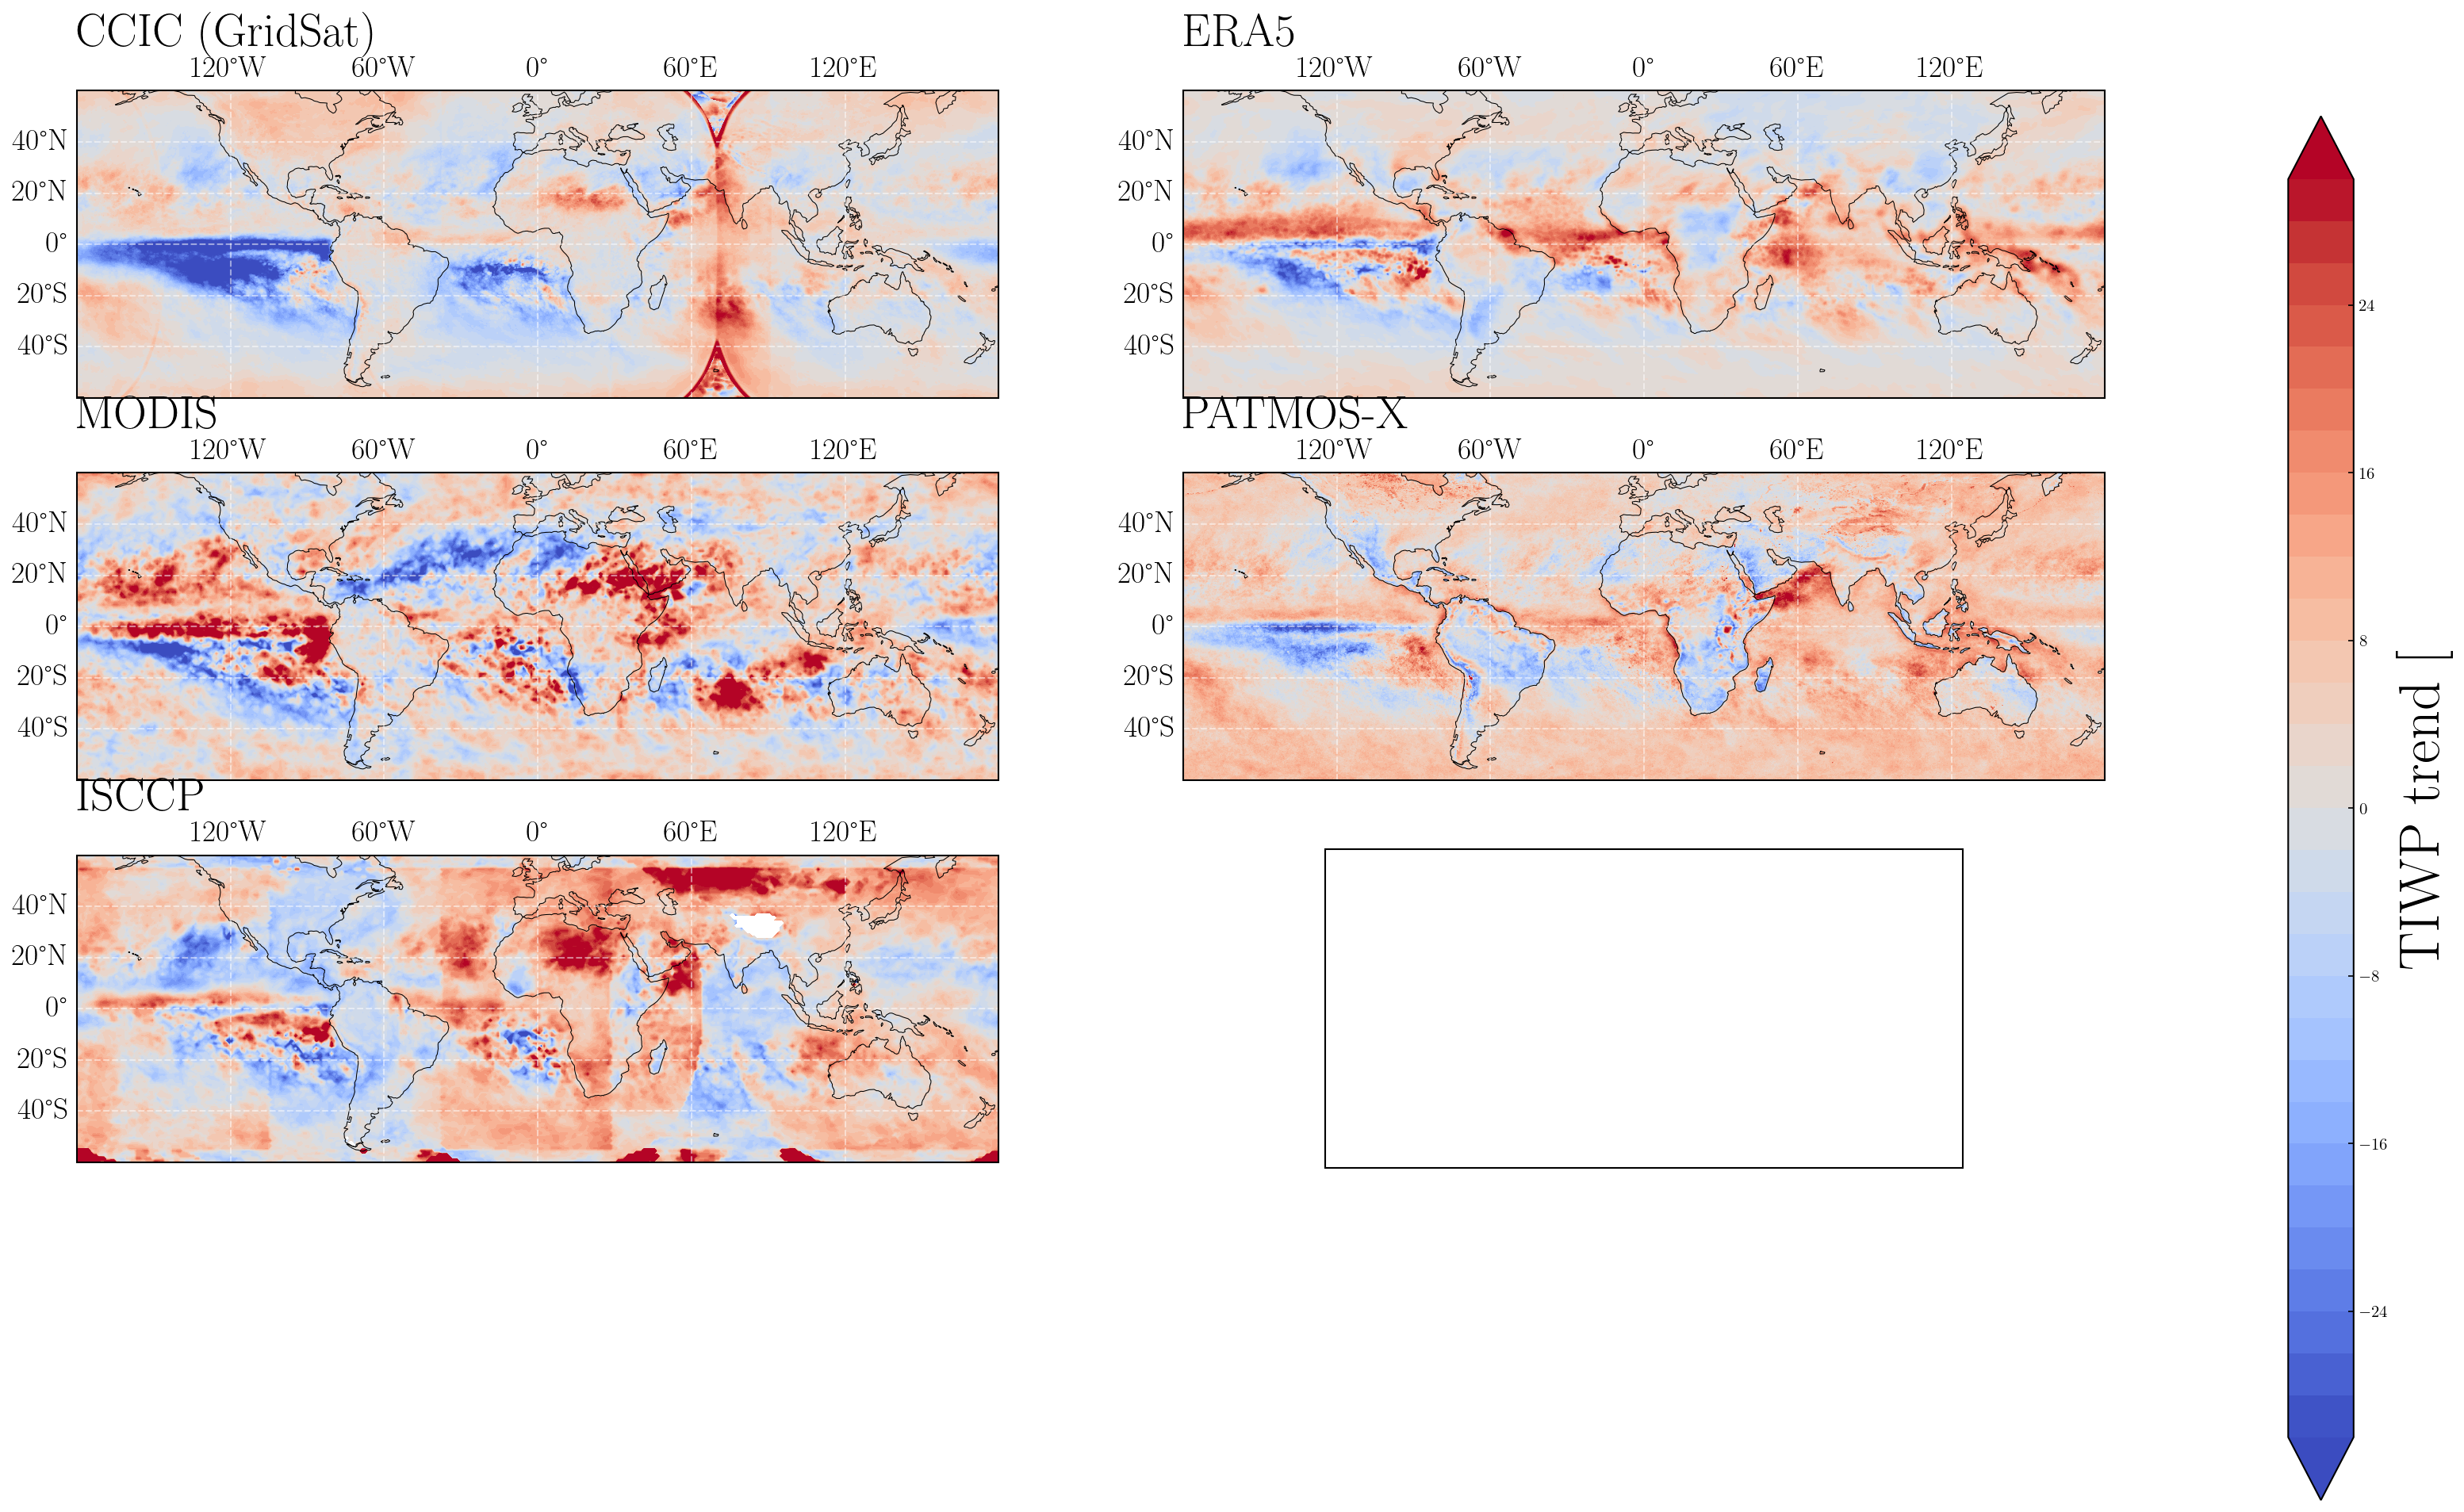

In [64]:
# Define the figure and each axis for the respective rows and columns 

nrows = 4 
ncols = 2 
fs = 28
datasets = [slope_ccic, slope_era, slope_modis, slope_patmos, slope_isccp]
ds_coordinates = [ccic_tiwp, era_tiwp, modis_tiwp, patmos_tiwp, isccp_tiwp] 
names = ['CCIC (GridSat)', 'ERA5', 'MODIS', 'PATMOS-X', 'ISCCP']
cmap = 'coolwarm' 

fig = plt.figure(figsize=(22, 16))

ax1 = plt.subplot2grid(shape=(nrows, ncols), loc=(0, 0), colspan=1, projection=ccrs.PlateCarree())
ax2 = plt.subplot2grid(shape=(nrows, ncols), loc=(0, 1), colspan=1, projection=ccrs.PlateCarree())
ax3  = plt.subplot2grid(shape= (nrows, ncols), loc=(1, 0), colspan=1, projection=ccrs.PlateCarree())
ax4  = plt.subplot2grid(shape= (nrows, ncols), loc=(1, 1), colspan=1, projection= ccrs.PlateCarree())
ax5  = plt.subplot2grid(shape= (nrows, ncols), loc=(2, 0), colspan=1, projection= ccrs.PlateCarree())
ax6  = plt.subplot2grid(shape= (nrows, ncols), loc=(2, 1), colspan=1, projection= ccrs.PlateCarree())
axs = [ax1, ax2, ax3, ax4, ax5] 


# Loop over all of the models
for i,dataset in enumerate(datasets):
    ds_coords = ds_coordinates[i]
    if names[i] == 'MODIS':
        lons = ds_coords.lon.data
        lats = np.flip(ds_coords.lat.data, axis = 0) 
    else: 
        # get coordinates
        lons = ds_coords.longitude
        lats = ds_coords.latitude
    # set extent 
    axs[i].set_extent([-180, 180, -60, 60])
    # Contour plot
    cs=axs[i].contourf(lons, lats, dataset* 100 ,
                      transform = ccrs.PlateCarree(),
                      levels = levels,
                      cmap=cmap ,extend='both')

    # Title each subplot with the name of the model
    axs[i].set_title(names[i], fontsize = fs)

    # Draw the coastines for each subplot
    axs[i].coastlines(resolution='110m')
    
    gl = axs[i].gridlines(crs=ccrs.PlateCarree(),
              draw_labels=True,
              linewidth=1,
              color='white',
              alpha=0.5,
              linestyle='--') 
    gl.bottom_labels = False
    gl.right_labels = False 
    gl.xlabel_style = {'size': 18, 'color': 'k'}
    gl.ylabel_style = {'color': 'k', 'size': 18 }

cbar_ax = fig.add_axes([0.97, 0.1, 0.025, 0.8])
fig.colorbar(cs, cax=cbar_ax).set_label(label =  'TIWP trend [kg m2$^{-1}$ yr$^{-1}$]' , size = 35) 
fig.colorbar(cs, cax=cbar_ax).set_label(label =  'TIWP trend [% $^{-decade}$]' , size = 35) 


plt.savefig(path / 'plots' / 'tiwp_spatial_trends_normalized.png', bbox_inches = 'tight')
plt.show()